In [89]:
#Cargando librerías 
import importlib
import positioning_sensors as ps
importlib.reload(ps)

import sensor_aptitude as apt
importlib.reload(apt)

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

import pandas as pd

plt.style.use("ggplot")

**aptitude function methods**

 W = i*a^(p)


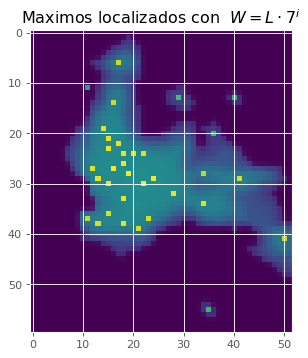

In [43]:
#cargamos imagenes en luminance e importance
ilumina = 'example/inputs/qro_light_th'
niveles = 'example/inputs/prioridades'
sigma_y = 0.5
sigma_x = 0.5
sigma = [sigma_y,sigma_x]

data = pd.read_csv("allcoversnonsatat15percent.csv")

luminance = ps.readIMG(ilumina)
importance = ps.readIMG(niveles,invert=True)

nonsat = ps.desaturate(luminance,th=62)
nonsat = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode='constant')

W1 = ps.f5(nonsat,importance,e=7)
seeds = ps.getMax(W1)

seeds_nonsat = ps.getMax(nonsat)
coords_nonsat = ps.get_coords(seeds_nonsat)

plt.figure(figsize=(5, 5), dpi=80)
plt.imshow(seeds*np.max(W1)/2+W1)
plt.imshow(seeds*np.max(nonsat)+nonsat)
plt.title("Maximos localizados con  $W = L \cdot 7^i$ ")
plt.show()

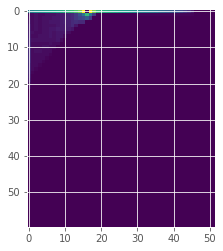

In [28]:
variograms  = np.array(data.iloc[0][3:]).reshape((nonsat.shape[0],nonsat.shape[1]))


In [93]:
variogram_set = np.array(data.iloc[:,3:])
coords = np.array(data.iloc[:,1:3])
variograms = variogram_set.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])

In [94]:
varmask = variograms

#searching and verifying valid coordinates 
#searching and verifying valid coordinates 

def validate_coordinates(iy,ix,coords=coords):
    iy = np.where(coords[:,0]==iy)
    ix = np.where(coords[:,1]==ix)

    ix = np.intersect1d(ix,iy)
    return ix

def aptitude(X,nonsat=nonsat,varmask=varmask,only_aptitude=True):
    
    M = mapa(X, nonsat, varmask)
    
    #creamos n mapas binarios donde la cobertura de los sensores no se traslape
    mask = np.sum(M>0,axis=0)==1
    
 #   np.sum([mask]*len(M)*M)

    return -(np.sum([mask]*len(M)*M))

                    
def mapa(X,nonsat=nonsat,varmask=varmask,W1=ps.f5(nonsat,importance,e=7)):
    
    
    n_sensors = int(len(X)/2)
    
    sensor_list = X.reshape(n_sensors,len(nonsat.shape))
    
    coverage = np.zeros((n_sensors,nonsat.shape[0],nonsat.shape[1]))
    
    for i,s in enumerate(sensor_list):

        sy = s[0]
        sx = s[1]
        #sy,sx = s[0],s[1]
        ix = validate_coordinates(sy,sx)
        
        coverage[i] = np.zeros(nonsat.shape)
 
        if len(ix)>0: 
            map0to1 = 1/(1+varmask[ix]) 
            coverage[i] = map0to1*(map0to1<1)*W1

 
    return coverage    
    


 W = i*a^(p)


In order to do so,  a sensitivity map $S$ is required. $S$ is the result of a combining function that merge two maps: the Nighttime Light Image (NTLI), and the Environmental Attention Map (EAM). We denote these as $M$ and $A$ respectively. 

**Measuring the "coverage quality" of each sensor location**


We need two maps: the NTLI nonsat, and the Environmental Attention MAP to produce a Sensitivity Map

 W = i*a^(p)


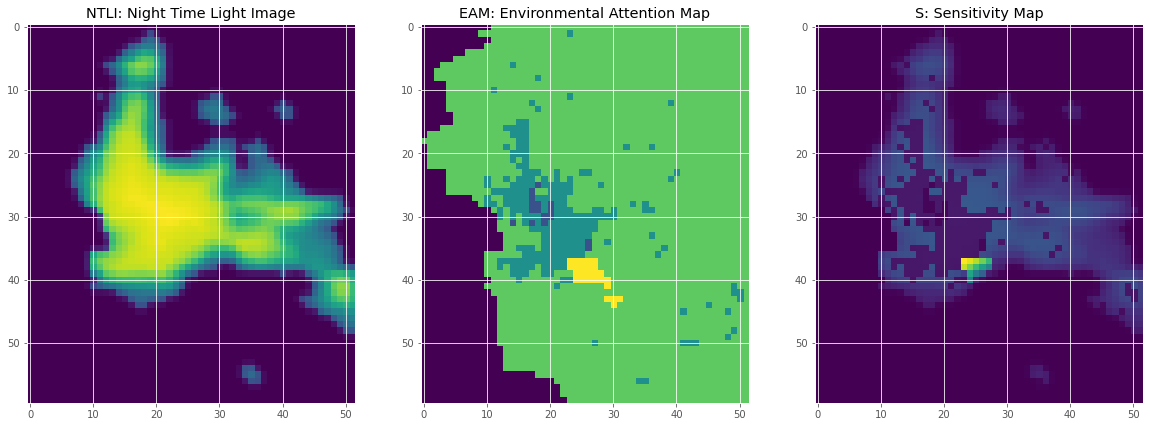

In [186]:
NTLI = nonsat
EAM = importance
fig, axs = plt.subplots(1, 3,figsize=(20,20))

axs[0].imshow(NTLI)
axs[0].title.set_text("NTLI: Night Time Light Image")
axs[1].imshow(EAM)
axs[1].title.set_text("EAM: Environmental Attention Map")
axs[2].imshow(ps.f5(NTLI,importance))
axs[2].title.set_text("S: Sensitivity Map")
plt.show()



# Measuring the quality of coverage of each sensor Location

we have a collection of locations $L=\{l_0,\dots,l_{p-1}\}$

Each location has associated an influence region computed by a (local) directed variogram function

$r_i = \text{variogram}(l_i,\text{NLTI})$ where $r_i\in R^{m \times n}$. $m \times n$ is a bidimensional matrix containing a map.


**Example of $r_i$**

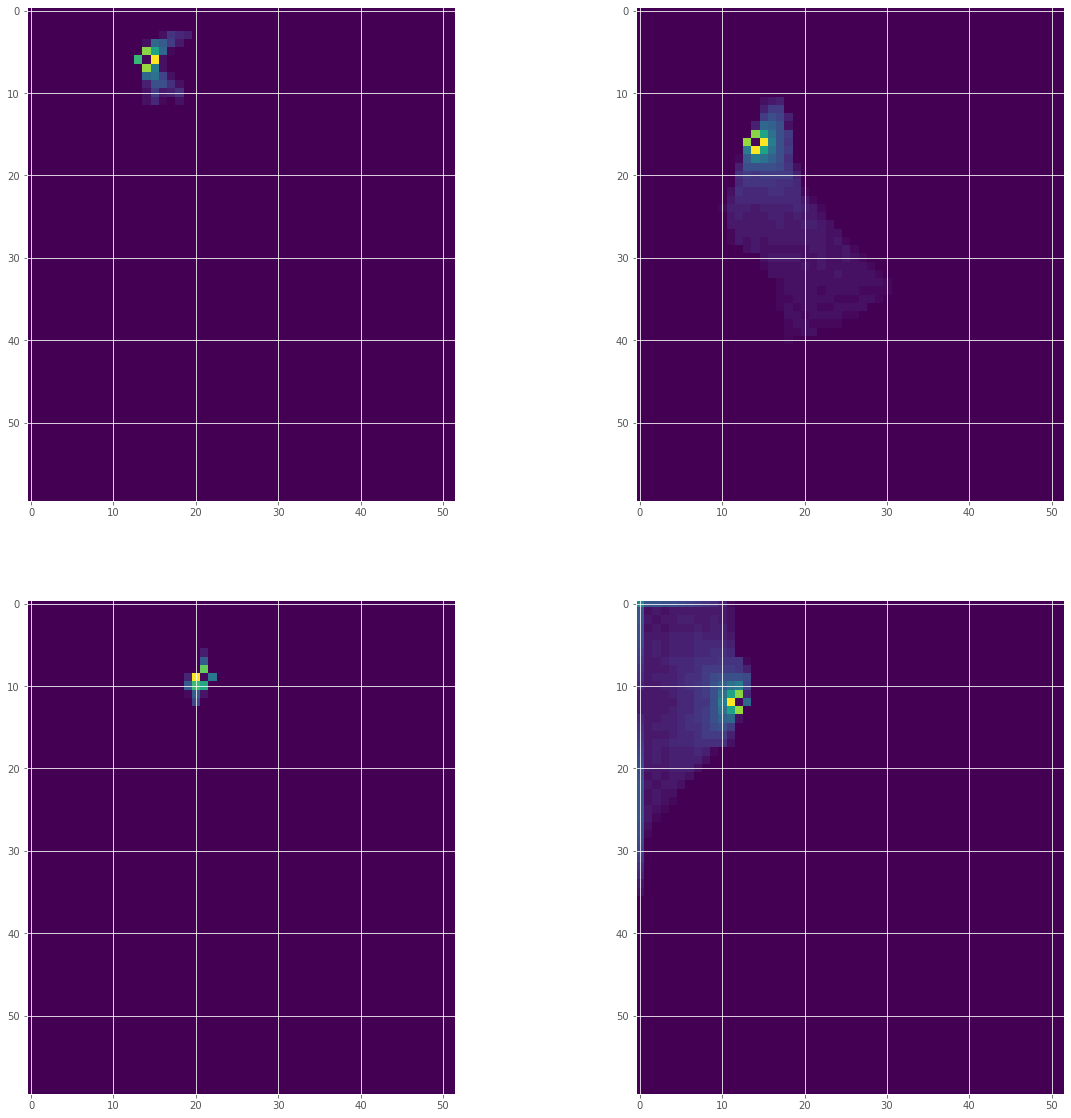

In [189]:
L = 2
selected_locations = [np.random.randint((len(varmask))) for i in np.arange(L**2)]

fig, axs = plt.subplots(L, L,figsize=(20,20))

for i,s in enumerate(selected_locations):
    sploty = i%L
    splotx = int(i/L)
    axs[sploty, splotx].imshow(varmask[s])

plt.show()

In order to measure the importance of each sensor location $l_i$ given its variogram $r_i$, we map the variogram values using a inverse function. 

We want to find the set of sensor locations that maximize a measure with the highest representativity value possible. This measure is the aptitude function. In order to proceed designing this function we asssume these facts.


1. We want to have low variogram values in a high sensitivity region. E.g., We want to locate a sensor exactly in the highest value of the sensitivity map. Therefore:


We map the variogram values, $M: r_i \in\{0,\infty\} \rightarrow r'_i \in \{0,1\}: $

Where e have a mapped version of the original variogram valueso into a new one where 1 means high importance and 0 null importance


$r'_i = 1/(1+r_i)$

Them we use $r'_i$ as spatial weights to measure the quality 

$rs^i = r'_i \cdot \text{regionS}(r_i)$

regionS, is the sensitivity region covered by the  variogram $r_i$

$rs^i \in R^{m,n}$

where $rs^i_{(i,j)} = 0 $ if the location $i,j$, is out of the variogram region.

The simplest case is whe we want to find the location $i$ that maximizes the value of $rs^i$

$$i = \underset{i \in \{0,\dots,p-1\}}{\text{ arg max }} rs^i$$

A more general case is when we want to find the best subset of sensor locations $L' \subset L$, where $|L'|=ns$ ($ns:$ number of sensors)


In this case we also want to reduce redundancy (Avoid multiple sensor cover the same subregion).

So, we need an aptitude function that penalizes the overlaping regions.

For a set of indexes associated sensor locations $\{i_1,i_2,i_j,\dots,i_{ns}\}$ where $i_j \in I$ and $I=\{0,1,\dots,p-1\}$

For a set of sensor regions, we appli the symetric difference


$$M = \oplus_{i \in \{I'\}} (rs_{i}>0)$$

$$V = \bigcup_{i \in \{I'\}} rs_{i})$$

$$
\underset{I'}{\text{ arg max }}\sum_i^m \sum_j^n (V \circ M)_{i,j}
$$

s.t.

$$I'=\{i'_0,i'_1,\dots,i'_{ns}\}$$

where:


$$i' \in \{0,1,\dots,p-1\}$$

[[ 0 60]
 [ 0 52]
 [ 0 60]
 [ 0 52]]
 The best solution found:                                                                           
 [18. 14. 26. 30.]

 Objective function:
 -1623403.468278729


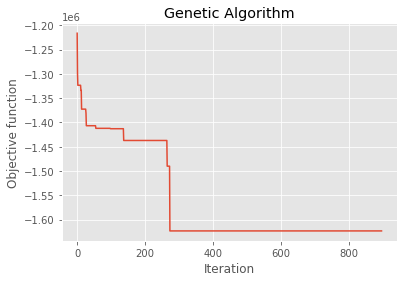

In [253]:
from geneticalgorithm import geneticalgorithm as ga

n_sensors = 2

#variable ranges, 2 ranges per sensor position (dim*n_sensors) 
varbound=np.array([[0,nonsat.shape[0]],[0,nonsat.shape[1]]]*n_sensors)
print(varbound)

dim = len(varbound)

#algorithms_parameters={'max_num_iteration': None, 'population_size': 500, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': None}

model=ga(function=aptitude,dimension=dim,variable_type='int',variable_boundaries=varbound)

model.run()

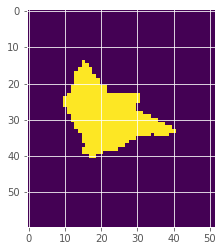

[23. 21.]


In [251]:
X = model.output_dict["variable"]
res = mapa(X)
c = 1
empty= np.zeros((res[0].shape[0],res[0].shape[1]))
for j,i in enumerate(res):
    empty = empty + (i>0)*(j+1)
    c += 1
    

coverage_importance = empty*np.max(W1)/2+W1
plt.imshow(empty)
plt.show()

Xs = X.reshape(int(len(X)/2),2) 
locations = np.zeros(nonsat.shape)
for x in Xs :
    print(x)
    locations[int(x[0])][int(x[1])] = 10


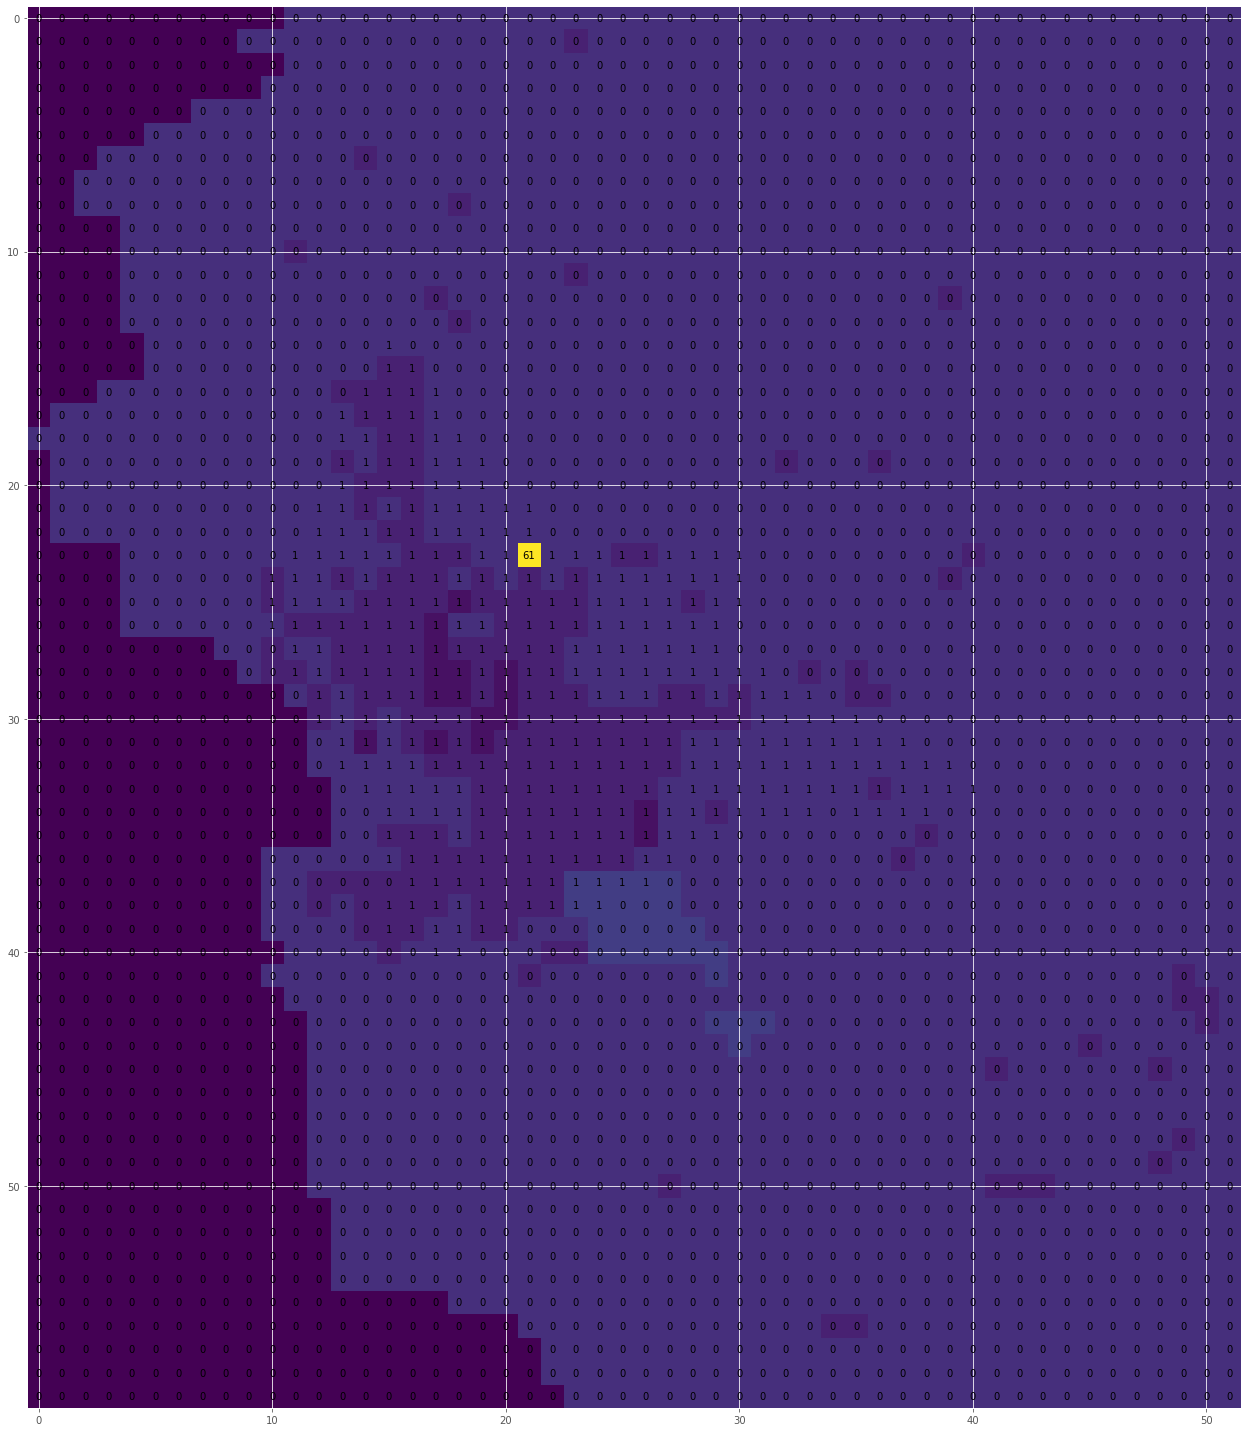

In [252]:
max_each_level = empty
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(EAM+locations*2)
for i in range((max_each_level.shape[0])):
    for j in range(max_each_level.shape[1]):
        text = ax.text(j, i, int(max_each_level[i, j]+locations[i,j]*6),
                       ha="center", va="center", color="black")

fig.tight_layout()
plt.show()

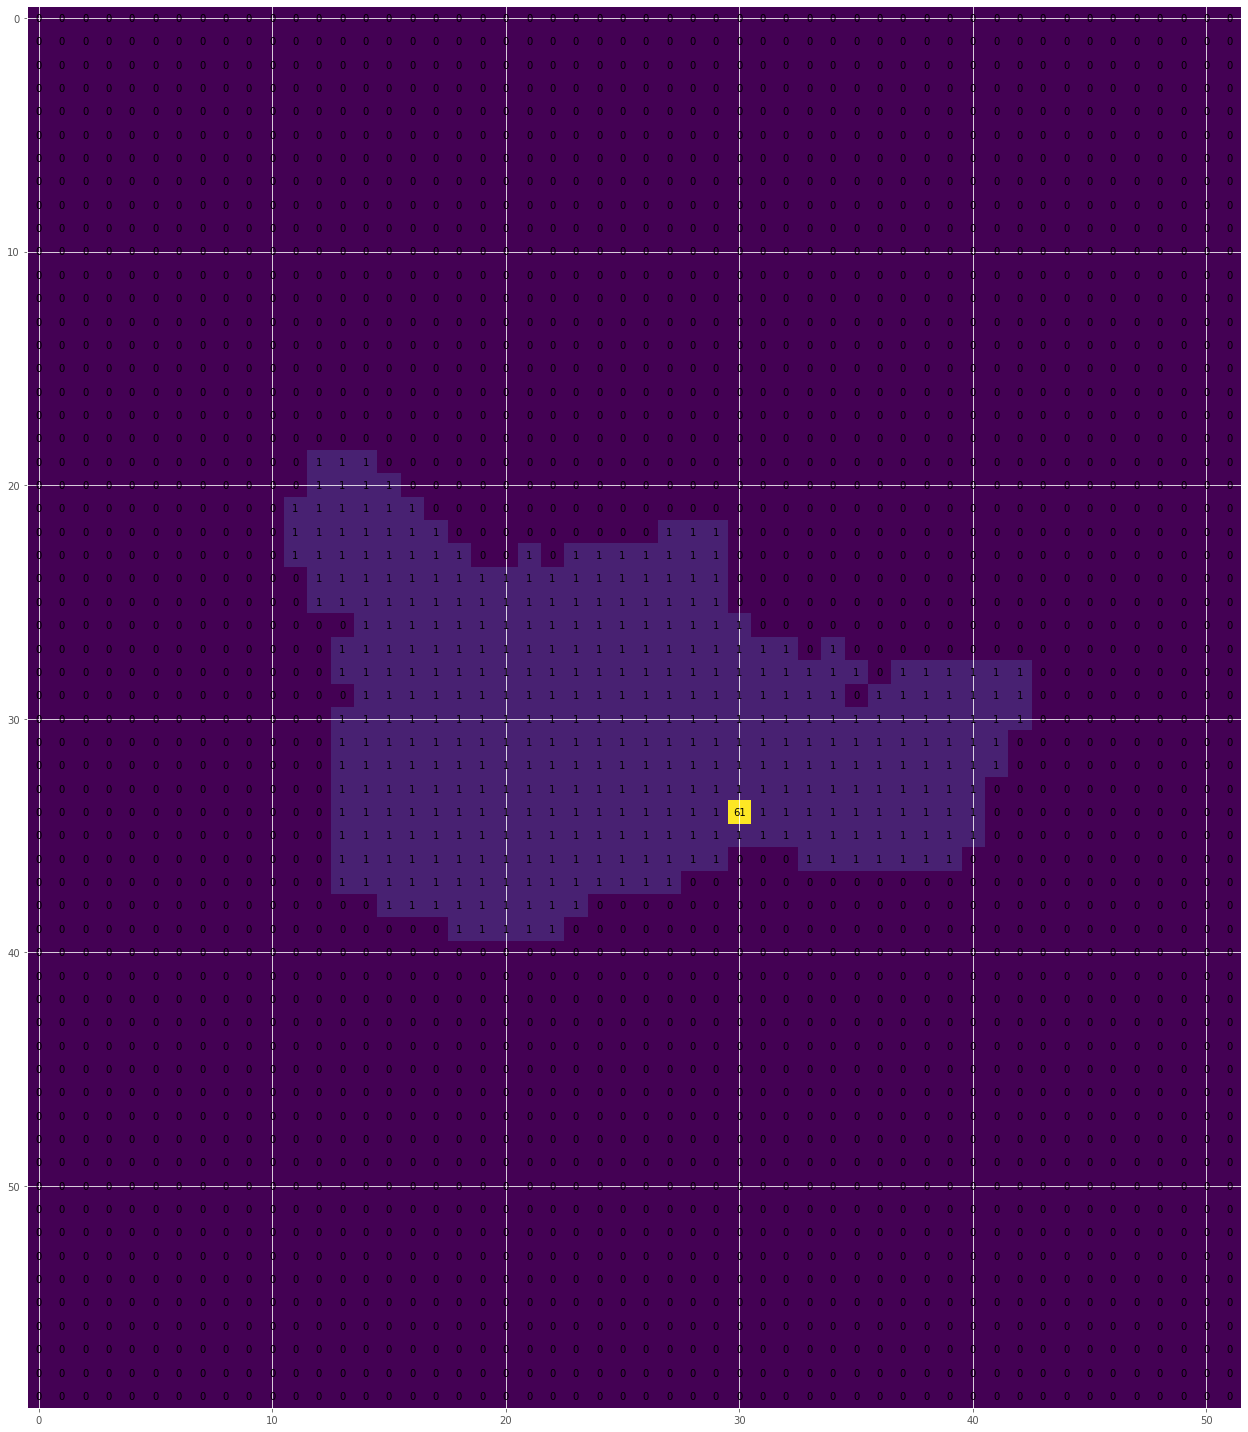

In [248]:
max_each_level = empty
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(max_each_level+locations)
for i in range((max_each_level.shape[0])):
    for j in range(max_each_level.shape[1]):
        text = ax.text(j, i, int(max_each_level[i, j]+locations[i,j]*6),
                       ha="center", va="center", color="black")

fig.tight_layout()
plt.show()

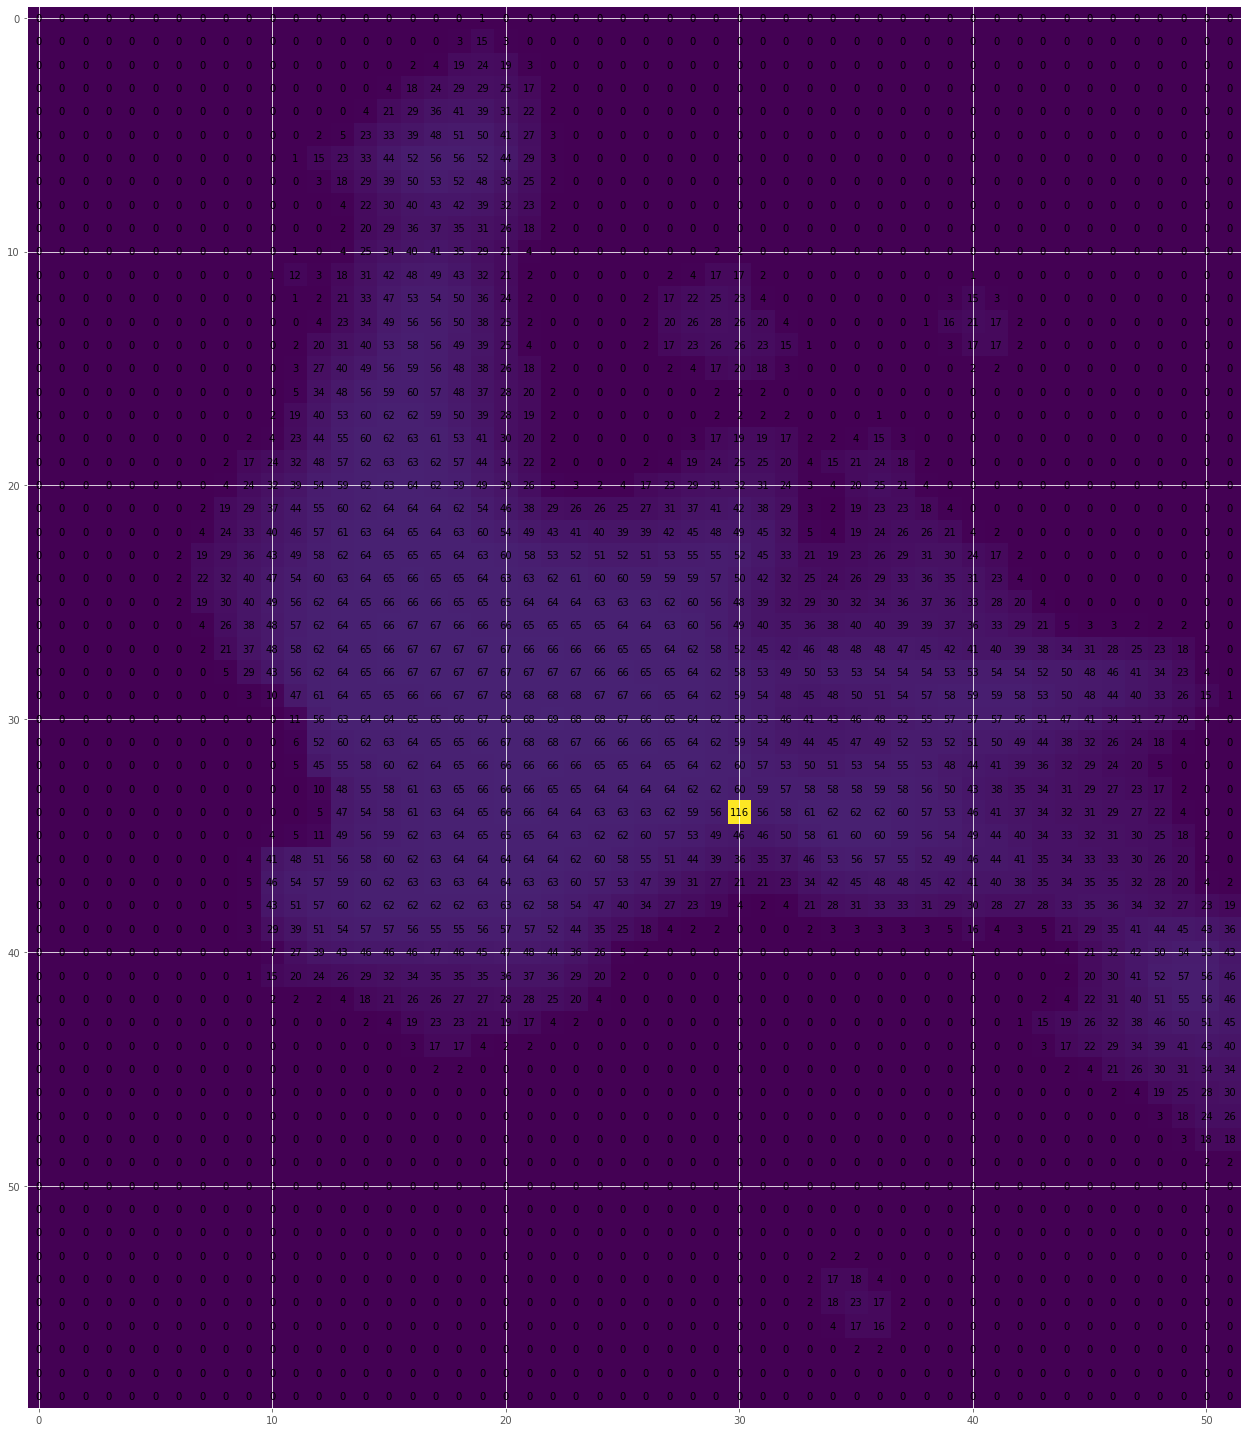

In [249]:
max_each_level = nonsat
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(max_each_level+locations*65)
for i in range((max_each_level.shape[0])):
    for j in range(max_each_level.shape[1]):
        text = ax.text(j, i, int(max_each_level[i, j]+locations[i,j]*6),
                       ha="center", va="center", color="black")

#plt.figure(figsize=(10, 10), dpi=80)
fig.tight_layout()
plt.show()

In [199]:
X = X.reshape((int(len(X)/2),2))


[15. 15.]
[30. 43.]
[40. 24.]
[37. 46.]
[22. 27.]


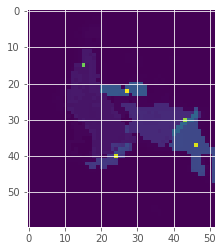

In [207]:
plt.imshow(coverage_importance+locations*100000)

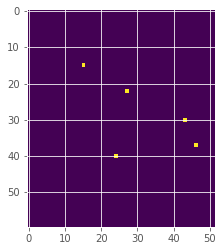

In [202]:
plt.imshow(locations)

In [218]:
help(ga)

Help on class geneticalgorithm in module geneticalgorithm.geneticalgorithm:

class geneticalgorithm(builtins.object)
 |  geneticalgorithm(function, dimension, variable_type='bool', variable_boundaries=None, variable_type_mixed=None, function_timeout=10, algorithm_parameters={'max_num_iteration': None, 'population_size': 100, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': None}, convergence_curve=True, progress_bar=True)
 |  
 |  Genetic Algorithm (Elitist version) for Python
 |  
 |  An implementation of elitist genetic algorithm for solving problems with
 |  continuous, integers, or mixed variables.
 |  
 |  
 |  
 |  Implementation and output:
 |      
 |      methods:
 |              run(): implements the genetic algorithm
 |              
 |      outputs:
 |              output_dict:  a dictionary including the best set of variables
 |          found and the value of